In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from medclip import MedCLIPModel, MedCLIPProcessor, PromptClassifier
from medclip.prompts import process_class_prompts, generate_chexpert_class_prompts, generate_covid_class_prompts
from medclip.dataset import ZeroShotImageDataset, ZeroShotImageCollator
from medclip.evaluator import Evaluator



## Step 1: Create metadata CSV for COVID dataset

The `ZeroShotImageDataset` expects a CSV file in `local_data/` directory with columns: `imgpath` and class labels.


In [3]:
# Create metadata CSV for COVID test dataset
covid_dir = Path('data/covid/COVID-19_Radiography_Dataset')

# Collect COVID images
covid_imgs = list((covid_dir / 'COVID' / 'images').glob('*.png'))
normal_imgs = list((covid_dir / 'Normal' / 'images').glob('*.png'))

print(f"Found {len(covid_imgs)} COVID images")
print(f"Found {len(normal_imgs)} Normal images")

num_sample_per_class = 3000
np.random.seed(42)

# Sample images
covid_imgs_sampled = np.random.choice(covid_imgs, size=num_sample_per_class, replace=False)
normal_imgs_sampled = np.random.choice(normal_imgs, size=num_sample_per_class, replace=False)

print(f"\nSampled {len(covid_imgs_sampled)} COVID images")
print(f"Sampled {len(normal_imgs_sampled)} Normal images")

# Create DataFrame
data = []
for img_path in covid_imgs_sampled:
    data.append({
        'imgpath': str(img_path),
        'COVID': 1,
        'Normal': 0,
    })

for img_path in normal_imgs_sampled:
    data.append({
        'imgpath': str(img_path),
        'COVID': 0,
        'Normal': 1,
    })

df = pd.DataFrame(data)
print(f"\nTotal images: {len(df)}")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nClass distribution:")
print(df[['COVID', 'Normal']].sum())


# Save sampled csv
output_path = Path('local_data/covid-test-meta.csv')
output_path.parent.mkdir(exist_ok=True)
df.to_csv(output_path)
print(f"\nSaved metadata to: {output_path}")

Found 3616 COVID images
Found 10192 Normal images

Sampled 3000 COVID images
Sampled 3000 Normal images

Total images: 6000

DataFrame shape: (6000, 3)

Class distribution:
COVID     3000
Normal    3000
dtype: int64

Saved metadata to: local_data/covid-test-meta.csv


## Step 2: Create ZeroShotImageDataset and DataLoader

In [4]:
# Define class names for COVID binary classification
class_names = ['COVID', 'Normal']

# Create dataset
dataset = ZeroShotImageDataset(
    datalist=['covid-test'],  # will load from local_data/covid-test-meta.csv
    class_names=class_names
)

print(f"Dataset size: {len(dataset)}")
print(f"Class names: {class_names}")

# Check a sample
img, label = dataset[0]
print(f"\nSample image shape: {img.shape}")
print(f"Sample label:")
print(label)

load data from ./local_data/covid-test-meta.csv
Dataset size: 6000
Class names: ['COVID', 'Normal']

Sample image shape: torch.Size([1, 1, 224, 224])
Sample label:
  COVID Normal
0     1      0


In [5]:
# Generate COVID class prompts
covid_prompts = generate_covid_class_prompts(n=12)
print(f"\nGenerated prompts for classes: {list(covid_prompts.keys())}")
print(f"Number of prompts per class: {[len(v) for v in covid_prompts.values()]}")

print(f"\nAvailable COVID prompts:")
for cls, prompts_list in covid_prompts.items():
    print(f"  {cls}: {len(prompts_list)} prompts")
    print(f"    Examples: {prompts_list[:2]}")

sample 12 num of prompts for COVID from total 12

Generated prompts for classes: ['COVID']
Number of prompts per class: [12]

Available COVID prompts:
  COVID: 12 prompts
    Examples: ['patchy ground glass opacity in peripheral', 'patchy ground glass opacity in mid']


In [6]:
# Create prompts for both COVID and Normal classes
# For Normal, we'll use "No Finding" style prompts
cls_prompts_dict = {
    'COVID': covid_prompts['COVID'],
    'Normal': [
        'no findings',
        'no evidence of pneumonia',
        'normal chest x-ray',
        'clear lungs',
        'no acute disease',
        'no radiographic abnormality',
        'healthy chest radiograph',
        'unremarkable chest x-ray',
        'no pathological findings',
        'normal cardiomediastinal silhouette',
        'no infiltrates',
        'normal pulmonary vasculature'
    ]
}

print(f"Class prompts prepared:")
for cls, prompts in cls_prompts_dict.items():
    print(f"  {cls}: {len(prompts)} prompts")


Class prompts prepared:
  COVID: 12 prompts
  Normal: 12 prompts


In [7]:
# Create collator with prompts
collator = ZeroShotImageCollator(
    mode='binary',  # binary classification: COVID vs Normal
    cls_prompts=cls_prompts_dict
)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collator,
    num_workers=2
)

print(f"DataLoader created with batch_size={batch_size}")
print(f"Number of batches: {len(dataloader)}")

# Test the dataloader
sample_batch = next(iter(dataloader))
print(f"\nSample batch keys: {sample_batch.keys()}")
print(f"Pixel values shape: {sample_batch['pixel_values'].shape}")
print(f"Labels shape: {sample_batch['labels'].shape}")
print(f"Prompt inputs keys: {sample_batch['prompt_inputs'].keys()}")

/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DataLoader created with batch_size=32
Number of batches: 188
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKEN

## Step 3: Evaluate using the PromptClassifier and Evaluator

In [8]:
# Initialize model and classifier (reusing from earlier cells)
processor = MedCLIPProcessor()
model = MedCLIPModel.from_pretrained(vision_model='resnet', device='mps')
clf = PromptClassifier(model, ensemble=False)
clf.to('mps')
clf.eval()

print("Model and classifier ready for evaluation")

/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/dongyoun/miniconda3/envs/medclip_eval/lib/python3.10/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data whi

Model moved to mps
load model weight from: pretrained/medclip-resnet
Model and classifier ready for evaluation


In [9]:
# Create evaluator
evaluator = Evaluator(
    medclip_clf=clf,
    eval_dataloader=dataloader,
    mode='binary'  # binary classification
)

print("Evaluator created, starting evaluation...")

Evaluator created, starting evaluation...


In [10]:
# Run evaluation
results = evaluator.evaluate()

# Display results
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)
for metric, value in results.items():
    if metric not in ['pred', 'labels']:
        print(f"{metric:20s}: {value:.4f}")
print("="*50)


Evaluation:   0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluation: 100%|██████████| 188/188 [01:13<00:00,  2.57it/s]


EVALUATION RESULTS
acc                 : 0.8082
precision           : 0.8086
recall              : 0.8082
f1-score            : 0.8081


In [11]:
results

{'pred': array([[ 0.23245667, -0.3774442 ],
        [ 0.08936121, -0.612458  ],
        [ 0.17332655, -0.5960146 ],
        ...,
        [-0.55776083, -0.03824956],
        [-0.65960926, -0.05561868],
        [-0.44368201,  0.1290193 ]], dtype=float32),
 'labels': array([0, 0, 0, ..., 1, 1, 1]),
 'acc': 0.8081666666666667,
 'precision': 0.8085891251790367,
 'recall': 0.8081666666666667,
 'f1-score': 0.8081009892302307}

## Optional: Analyze predictions in detail


In [12]:
# Get predictions and labels
predictions = results['pred']
labels = results['labels']

# Convert to predicted labels
pred_scores = torch.tensor(predictions).sigmoid().numpy()
pred_labels = np.argmax(pred_scores, 1)

print(f"Predictions shape: {predictions.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nPredicted class distribution:")
print(f"  COVID (predicted): {np.sum(pred_labels == 0)}")
print(f"  Normal (predicted): {np.sum(pred_labels == 1)}")
print(f"\nTrue class distribution:")
print(f"  COVID (true): {np.sum(labels == 0)}")
print(f"  Normal (true): {np.sum(labels == 1)}")


Predictions shape: (6000, 2)
Labels shape: (6000,)

Predicted class distribution:
  COVID (predicted): 2889
  Normal (predicted): 3111

True class distribution:
  COVID (true): 3000
  Normal (true): 3000



Confusion Matrix:
                Predicted
              COVID  Normal
Actual COVID   2369    631
       Normal   520   2480


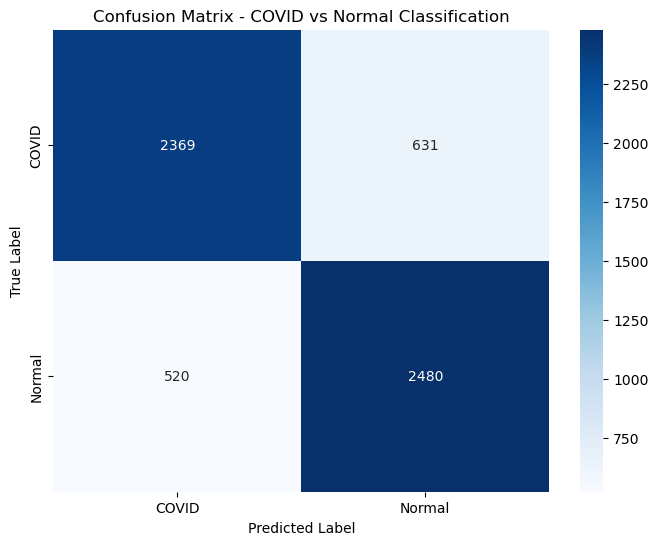

In [13]:
# Show confusion matrix
cm = confusion_matrix(labels, pred_labels)
print("\nConfusion Matrix:")
print(f"                Predicted")
print(f"              COVID  Normal")
print(f"Actual COVID   {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"       Normal  {cm[1,0]:4d}   {cm[1,1]:4d}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['COVID', 'Normal'],
            yticklabels=['COVID', 'Normal'])
plt.title('Confusion Matrix - COVID vs Normal Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [14]:
# Get the class names from a sample batch
sample_batch = next(iter(dataloader))
outputs = clf(**sample_batch)
class_names = outputs['class_names']

print("Class name to index mapping:")
for idx, name in enumerate(class_names):
    print(f"  Index {idx} = {name}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Class name to index mapping:
  Index 0 = COVID
  Index 1 = Normal
